In [1]:
from pathlib import Path

In [2]:
import pandas as pd
import numpy as np
import string

In [3]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [4]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD

#### Directories

In [5]:
proj_dir = Path().absolute().parents[0]
data_dir = Path(proj_dir, 'data')

#### Read in data

In [6]:
reviews = pd.read_csv(Path(data_dir, 'raw', 'comcast_consumeraffairs_complaints.csv'))

In [7]:
reviews.head()

,author,posted_on,rating,text
0,"Alantae of Chesterfeild, MI","Nov. 22, 2016",1,I used to love Comcast. Until all these consta...
1,"Vera of Philadelphia, PA","Nov. 19, 2016",1,I'm so over Comcast! The worst internet provid...
2,"Sarah of Rancho Cordova, CA","Nov. 17, 2016",1,If I could give them a negative star or no sta...
3,"Dennis of Manchester, NH","Nov. 16, 2016",1,I've had the worst experiences so far since in...
4,"Ryan of Bellevue, WA","Nov. 14, 2016",1,Check your contract when you sign up for Comca...


#### Plot ratings

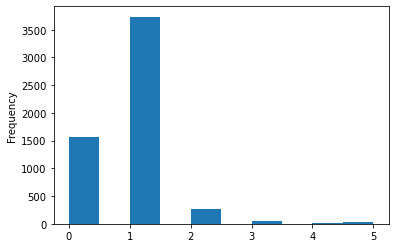

In [8]:
reviews['rating'].plot.hist()

#### Tokenize

In [9]:
spacy_nlp = spacy.load('en_core_web_sm')
stop_words = STOP_WORDS
punctuations = string.punctuation

In [10]:
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = spacy_nlp(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [11]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, max_features = 10000)

In [12]:
reviews['text'] = reviews['text'].astype('str')

In [13]:
tfidf_vector.fit(reviews['text'])

D:\ProgramData\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=10000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x0000018B28020678>,
                use_idf=True, vocabulary=None)

In [14]:
dtm = tfidf_vector.transform(reviews['text'])

In [15]:
dtm.shape

(5659, 10000)

#### N topics

In [16]:
n_topics = 20

#### SVD

In [17]:
svd = TruncatedSVD(n_components=n_topics, random_state=123)
svd.fit(dtm)

TruncatedSVD(algorithm='randomized', n_components=20, n_iter=5,
             random_state=123, tol=0.0)

In [18]:
svd.transform(dtm).shape

(5659, 20)

In [19]:
svd.transform(dtm)

array([[ 0.1411988 , -0.05080584,  0.11678394, ...,  0.01082912,
         0.00381002,  0.03376831],
       [ 0.20315614, -0.0205252 ,  0.12208096, ...,  0.01179634,
        -0.01131184, -0.02837379],
       [ 0.24135629,  0.02432883,  0.03564981, ...,  0.01654153,
        -0.0351021 ,  0.01836622],
       ...,
       [ 0.21281701,  0.06177949,  0.02420473, ...,  0.05969446,
         0.03399697, -0.11266856],
       [ 0.26173268,  0.11089373,  0.08535219, ...,  0.00848069,
        -0.03227742,  0.12586026],
       [ 0.31867022, -0.14923647,  0.11316476, ...,  0.03356217,
         0.00706531, -0.08415831]])

In [20]:
svd.components_.shape

(20, 10000)

In [21]:
terms = tfidf_vector.get_feature_names()

for i, comp in enumerate(svd.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    print([x[0] for x in sorted_terms])

Topic 0: 
['service', 'comcast', 'tell', 'bill', 'time', 'customer', 'internet']
Topic 1: 
['bill', 'month', 'charge', 'pay', 'fee', 'payment', 'account']
Topic 2: 
['internet', 'speed', 'channel', 'cable', 'tv', 'box', 'month']
Topic 3: 
['box', 'cable', 'channel', 'tell', 'bill', 'charge', 'come']
Topic 4: 
['modem', 'speed', 'internet', 'bill', 'tech', 'charge', 'problem']
Topic 5: 
['nan', 'technician', 'company', 'agent', 'tech', 'send', 'issue']
Topic 6: 
['account', 'box', 'comcast', 'modem', 'equipment', 'return', 'collection']
Topic 7: 
['modem', 'tell', 'contract', 'package', 'price', 'channel', 'sign']
Topic 8: 
['charge', 'service', 'modem', 'equipment', 'customer', 'fee', 'return']
Topic 9: 
['appointment', 'speed', 'internet', 'comcast', 'cancel', 'technician', 'tell']
Topic 10: 
['speed', 'box', 'charge', 'customer', 'high', 'minute', 'hold']
Topic 11: 
['...', 'equipment', 'company', 'bad', 'box', 'cable', 'return']
Topic 12: 
['phone', 'service', 'internet', 'bill', 'n

#### NMF

In [22]:
nmf = NMF(n_components=n_topics, random_state=123)
nmf.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=20, random_state=123, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [23]:
nmf.transform(dtm).shape

(5659, 20)

In [24]:
nmf.transform(dtm)

array([[0.00843275, 0.        , 0.06190026, ..., 0.01538264, 0.        ,
        0.02281553],
       [0.03502386, 0.00643227, 0.07647008, ..., 0.        , 0.        ,
        0.00115703],
       [0.0373439 , 0.01353162, 0.00938223, ..., 0.03601864, 0.00542564,
        0.        ],
       ...,
       [0.01570732, 0.02413563, 0.00584491, ..., 0.00264618, 0.02798736,
        0.0069851 ],
       [0.01643588, 0.04492623, 0.02450606, ..., 0.        , 0.        ,
        0.07182602],
       [0.00618971, 0.        , 0.01705933, ..., 0.        , 0.        ,
        0.00362692]])

In [25]:
nmf.components_.shape

(20, 10000)

In [26]:
terms = tfidf_vector.get_feature_names()

for i, comp in enumerate(nmf.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:9]
    print("Topic "+str(i)+": ")
    print([x[0] for x in sorted_terms])

Topic 0: 
['company', 'bad', 'customer', 'comcast', 'time', 'deal', 'like', 'people', 'business']
Topic 1: 
['bill', 'month', 'pay', 'receive', 'late', 'dollar', 'credit', 'owe', 'billing']
Topic 2: 
['internet', 'tv', 'work', 'use', 'connection', 'day', 'month', 'comcast', 'phone']
Topic 3: 
['box', 'new', 'dvr', 'tv', 'hd', 'work', 'send', 'remote', 'replace']
Topic 4: 
['modem', 'comcast', 'buy', 'router', 'new', 'rental', 'use', 'purchase', 'replace']
Topic 5: 
['nan', 'xfinity', 'card', 'wifi', 'store', 'recommend', 'alarm', 'experience', 'security']
Topic 6: 
['account', 'payment', 'credit', 'comcast', 'bank', 'check', 'email', 'money', 'collection']
Topic 7: 
['contract', 'year', 'sign', 'price', 'month', 'rate', 'fee', '2', 'increase']
Topic 8: 
['service', 'customer', 'cancel', 'poor', 'comcast', 'disconnect', 'provide', 'representative', 'rep']
Topic 9: 
['appointment', 'technician', 'schedule', 'day', 'come', 'pm', 'wait', 'home', 'reschedule']
Topic 10: 
['speed', 'high', '

#### test coherence

In [27]:
index = 5657

In [28]:
reviews.text[index]

"I am being ripped of by Comcast Cable regarding my billing.  I have had expanded/standard cable for years.  (The monthly cost for my area on their internet site states $32.78 per month), (the recent letter I received from Comcast states prices for my area also states $32.78 per month). My bill states I have cable (video) services which is not available in my area, and this is stated on comcast's internet site.  Ms. Talley states she did not know why this was on my bill.  I have got the run around period from comcast/employees with no solution to my problem.  I have copies of all e-mails I have written and all copies comcast have written me, I also have years of past receipts where I paid  and have been over charged for cable with comcast, and customer service does not seem to care or want to help me."

In [29]:
nmf.transform(dtm)[index]

array([0.01643588, 0.04492623, 0.02450606, 0.        , 0.00346126,
       0.        , 0.01348253, 0.0340244 , 0.01579923, 0.        ,
       0.00390826, 0.0213415 , 0.        , 0.        , 0.01571784,
       0.02144696, 0.        , 0.        , 0.        , 0.07182602])

In [30]:
nmf.transform(dtm)[index].argmax()

19

In [31]:
nmf.transform(dtm).argmax(axis = 1)

array([ 2,  2,  8, ..., 14, 19, 11], dtype=int64)

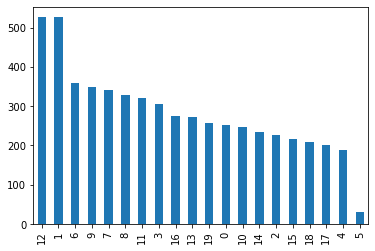

In [32]:
pd.Series(nmf.transform(dtm).argmax(axis = 1)).value_counts().plot.bar()

In [33]:
nmf.transform(dtm).shape

(5659, 20)

In [34]:
from gensim.test.utils import common_corpus, common_dictionary

In [35]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.coherencemodel import CoherenceModel
topics = [
    ['human', 'computer', 'system', 'interface'],
    ['graph', 'minors', 'trees', 'eps']
]

cm = CoherenceModel(topics=topics, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value

In [36]:
coherence

-7.105015580153772

In [37]:
common_corpus

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]

In [38]:
common_dictionary.id2token

{}

In [39]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.hdpmodel import HdpModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet
from gensim.corpora.dictionary import Dictionary
from numpy import array

In [40]:
texts = [['human', 'interface', 'computer'],
         ['survey', 'user', 'computer', 'system', 'response', 'time'],
         ['eps', 'user', 'interface', 'system'],
         ['system', 'human', 'system', 'eps'],
         ['user', 'response', 'time'],
         ['trees'],
         ['graph', 'trees'],
         ['graph', 'minors', 'trees'],
         ['graph', 'minors', 'survey']]

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [41]:
dictionary.token2id

{'computer': 0,
 'human': 1,
 'interface': 2,
 'response': 3,
 'survey': 4,
 'system': 5,
 'time': 6,
 'user': 7,
 'eps': 8,
 'trees': 9,
 'graph': 10,
 'minors': 11}

In [42]:
hm = HdpModel(corpus=corpus, id2word=dictionary)

In [43]:
hm.show_topics(num_topics=10, formatted=False)

[(0,
  [('computer', 0.22919730322038587),
   ('trees', 0.19566307632699254),
   ('graph', 0.17972449969561735),
   ('human', 0.10696362439309584),
   ('response', 0.07735008058757822),
   ('user', 0.06256748151584882),
   ('minors', 0.062432369620156705),
   ('interface', 0.03563775548819743),
   ('survey', 0.026493694413953117),
   ('system', 0.010491117483136867),
   ('eps', 0.009284985800516812),
   ('time', 0.004194011454520406)]),
 (1,
  [('minors', 0.2022064722070997),
   ('survey', 0.1402907880940196),
   ('user', 0.13371366876740676),
   ('computer', 0.12914185443910675),
   ('system', 0.10616280937423497),
   ('response', 0.09942144387100194),
   ('graph', 0.09427772670254696),
   ('eps', 0.02936069074333337),
   ('interface', 0.02508598106947985),
   ('trees', 0.019462396887658506),
   ('time', 0.017315067439665578),
   ('human', 0.0035611004044461035)]),
 (2,
  [('system', 0.29912426885426935),
   ('computer', 0.18389010156948754),
   ('survey', 0.15773775546939414),
   ('t

In [44]:
# To get the topic words from the model
topics = []
for topic_id, topic in hm.show_topics(num_topics=10, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)
topics[:2]

[['computer',
  'trees',
  'graph',
  'human',
  'response',
  'user',
  'minors',
  'interface',
  'survey',
  'system',
  'eps',
  'time'],
 ['minors',
  'survey',
  'user',
  'computer',
  'system',
  'response',
  'graph',
  'eps',
  'interface',
  'trees',
  'time',
  'human']]

In [45]:
# Initialize CoherenceModel using `topics` parameter
cm = CoherenceModel(topics=topics, corpus=corpus, texts=texts, dictionary=dictionary, coherence='c_v')
cm.get_coherence()

0.38384135537372027